# Model ResNet

https://www.pluralsight.com/guides/introduction-to-resnet

#### TODOS
1. DONE Debugging, does output make sense?
    1. Resize images
    2. preprocessing fixes
    5. replace scaling by proper function
2. try on leaderboard
3. Include Odometry and fuse into heads
    - Speed
    - Location
4. navigation
5. controller
6. Evaluation on Test set, Modularization



## Dependencies

In [1]:
# MODEL STUFF
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

# GENERAL STUFF
import time
import copy
import os
import sys
#sys.path.insert(1, 'C:\\Users\\morit\\OneDrive\\UNI\\Master\\WS22\\APP-RAS\\Programming\\data_pipeline') # TODO

# DATA ENGINEERING
from data_pipeline.dataset_xy import CARLADatasetXY
from data_pipeline.dataset import CARLADataset
from data_pipeline.utils import train_test_split, create_metadata_df, measurements_to_df, render_example_video_from_folder_name
from data_pipeline.data_sampler import BranchPerCommandSampler

import pandas as pd
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Model

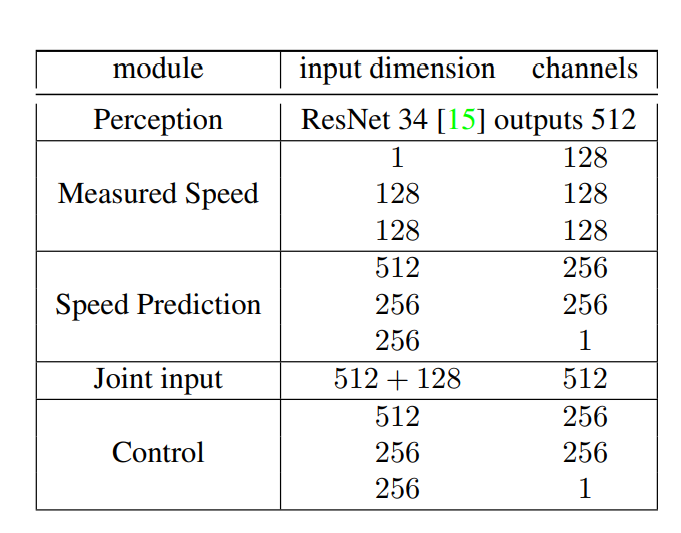

## Configs etc, paths

In [2]:
path = os.path.join("D:\\","data","all")
path_noise = os.path.join("D:\\","data","Noise")#D:\data\Train

# Now try with capsulated function from utils
config = {"used_inputs": ["rgb","measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "seq_len": 1
        }

train_test_config = {
    "train": ['Town00', 'Town01', 'Town02', 'Town03', 'Town04', 'Town05', 'Town07', 'Town08', 'Town09', 'Town10'],
    "test": ['Town06']
}

## BalancedData Loaders, Data Sets

In [3]:
# Create df_meta 
df_meta_data = create_metadata_df(path, config["used_inputs"])
noise_dataset_meta = create_metadata_df(path_noise, config["used_inputs"])

df_meta_train, df_meta_test, df_meta_test_2 = train_test_split(df_meta_data, train_test_config, df_meta_data_noisy = noise_dataset_meta)

#df_measurements_train = measurements_to_df(df_meta_train)
#df_measurements_test = measurements_to_df(df_meta_test)

In [4]:
#df_measurements_train.to_pickle("df_measurements_train.pickle")
#df_measurements_test.to_pickle("df_measurements_test.pickle")

In [5]:
df_measurements_train = pd.read_pickle("df_measurements_train.pickle")
df_measurements_test = pd.read_pickle("df_measurements_test.pickle")

In [6]:
batch_size = 6*10*2

train_dataset = CARLADataset(path, df_meta_train, config)
test_dataset = CARLADataset(path, df_meta_test, config)
test_dataset_2 = CARLADataset(path, df_meta_test_2, config)

train_weighted_sampler = BranchPerCommandSampler(train_dataset, df_measurements_train, batch_size)
test_weighted_sampler = BranchPerCommandSampler(test_dataset, df_measurements_test, batch_size)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, sampler = train_weighted_sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # TODO
"""
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
"""

'\ntrain_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\ntest_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)\n'

## Old Dataloaders

In [7]:
"""
batch_size = 64

#path_ege_data = os.path.join("..", "..", "data", "Dataset Ege")
train_path = "D:\\data\\Train"
test_path = "D:\\data\\Test"

config = {"used_inputs": ["rgb","measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "seq_len": 1
        }

train_meta= create_metadata_df(train_path, config["used_inputs"])
test_meta = create_metadata_df(test_path, config["used_inputs"])

train_dataset = CARLADataset(root_dir=train_path, df_meta_data=train_meta, config=config)
test_dataset = CARLADataset(root_dir=test_path, df_meta_data=test_meta, config=config)

#weighted_sampler = WeightedSampler(dataset=train_dataset)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
"""

'\nbatch_size = 64\n\n#path_ege_data = os.path.join("..", "..", "data", "Dataset Ege")\ntrain_path = "D:\\data\\Train"\ntest_path = "D:\\data\\Test"\n\nconfig = {"used_inputs": ["rgb","measurements"], \n        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],\n        "seq_len": 1\n        }\n\ntrain_meta= create_metadata_df(train_path, config["used_inputs"])\ntest_meta = create_metadata_df(test_path, config["used_inputs"])\n\ntrain_dataset = CARLADataset(root_dir=train_path, df_meta_data=train_meta, config=config)\ntest_dataset = CARLADataset(root_dir=test_path, df_meta_data=test_meta, config=config)\n\n#weighted_sampler = WeightedSampler(dataset=train_dataset)\n\n\ntrain_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\ntest_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)\n'

#### Check

In [8]:
len(train_dataloader)

1796

In [9]:
len(test_dataloader)

145

### Augumentations, Transformations

In [10]:
"""
augumentations = torch.nn.ModuleList([
        transforms.GaussianBlur(9),
        transforms.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
        transforms.RandomErasing()
    ])
"""
augumentations = transforms.AugMix()

"""
transform_augument = transforms.Compose([
    transforms.RandomApply(transforms.AugMix(),p = 0.2),
    transforms.RandomApply(transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),p=0.2)
])
"""


'\ntransform_augument = transforms.Compose([\n    transforms.RandomApply(transforms.AugMix(),p = 0.2),\n    transforms.RandomApply(transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),p=0.2)\n])\n'

In [11]:
mean = torch.tensor([105.6161, 81.5673, 79.6657]) # RGB
std = torch.tensor([66.2220, 60.1001, 66.8309])

transform_resize = transforms.Resize([224,224])
transform_augument = transforms.AugMix()
transform_norm = transforms.Normalize(mean, std)

## Training

### New Forward Pass for weighted Loss

In [12]:
def to_cuda_if_possible(data):
    return data.to(device) if device else data
"""
def forward_pass(data, augument = False, balance_cmd = False):
    # further preprocessing
    X_rgb = transform_norm(torch.squeeze(data["rgb"])).float()
    if augument:#:
        X_rgb = transform_augument(X_rgb)
    labels = data["command"]
    labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
    
    # Convert the labels to a one hot encoded tensor
    one_hot = to_cuda_if_possible(torch.nn.functional.one_hot(labels, num_classes=7))
    X_cmd = torch.squeeze(one_hot).float()
    X_spd = ((data["speed"]-speed_mean)/speed_std).float()
    
    Y_throttle = data["throttle"].float()
    Y_steer = data["steer"].float()
    Y_brake = data["brake"].float()

    # move to GPU
    X_rgb = to_cuda_if_possible(X_rgb)
    X_cmd = to_cuda_if_possible(X_cmd)
    X_spd = to_cuda_if_possible(X_spd)
    Y_throttle = to_cuda_if_possible(Y_throttle)
    Y_steer = to_cuda_if_possible(Y_steer)
    Y_brake = to_cuda_if_possible(Y_brake)

    # compute outputs
    optimizer.zero_grad()

    Y_hat = net(X_rgb, X_cmd, X_spd)
    Y_hat_throttle = to_cuda_if_possible(Y_hat[2])
    Y_hat_steer = to_cuda_if_possible(Y_hat[1])
    Y_hat_brake = to_cuda_if_possible(Y_hat[0])

    # get labels from data
    Y_throttle = to_cuda_if_possible(data["throttle"].float())
    Y_steer = to_cuda_if_possible(data["steer"].float())
    Y_brake = to_cuda_if_possible(data["brake"].float())

    # Calculate Loss# Balancing
    test = torch.mul(one_hot,inverse_scaled)
    if balance_cmd:
        weights = to_cuda_if_possible(torch.sum(test, dim=2))# TODO: Wierd behavior in training
    else:
        weights = torch.unsqueeze(torch.tensor(1,device = device),0)
    
    loss_throttle = 0.5*torch.mul(weights,criterion(Y_hat_throttle, Y_throttle))
    loss_steer = 0.45*torch.mul(weights,criterion(Y_hat_steer, Y_steer))
    loss_brake = 0.05*torch.mul(weights,criterion(Y_hat_brake, Y_brake))
    
    loss = torch.mean(torch.cat((loss_throttle, loss_steer, loss_brake),axis=0),axis=0)*3

    return loss

class_counts = np.array([29312,23808,23552,158400,11776,11776])

class_counts = class_counts/sum(class_counts)

inverse = 1/(class_counts)

inverse_scaled = inverse/sum(inverse)*7

inverse_scaled = torch.from_numpy(inverse_scaled)

inverse_scaled = torch.cat((torch.unsqueeze(torch.tensor(0),0),inverse_scaled),axis=0)

inverse_scaled = to_cuda_if_possible(inverse_scaled)

inverse_scaled
"""

'\ndef forward_pass(data, augument = False, balance_cmd = False):\n    # further preprocessing\n    X_rgb = transform_norm(torch.squeeze(data["rgb"])).float()\n    if augument:#:\n        X_rgb = transform_augument(X_rgb)\n    labels = data["command"]\n    labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0\n    \n    # Convert the labels to a one hot encoded tensor\n    one_hot = to_cuda_if_possible(torch.nn.functional.one_hot(labels, num_classes=7))\n    X_cmd = torch.squeeze(one_hot).float()\n    X_spd = ((data["speed"]-speed_mean)/speed_std).float()\n    \n    Y_throttle = data["throttle"].float()\n    Y_steer = data["steer"].float()\n    Y_brake = data["brake"].float()\n\n    # move to GPU\n    X_rgb = to_cuda_if_possible(X_rgb)\n    X_cmd = to_cuda_if_possible(X_cmd)\n    X_spd = to_cuda_if_possible(X_spd)\n    Y_throttle = to_cuda_if_possible(Y_throttle)\n    Y_steer = to_cuda_if_possible(Y_steer)\n    Y_brake = to_cuda_if_possible(Y_

### Old Forward Pass

In [13]:

def forward_pass(data, augument = True):
    # further preprocessing
    if augument:#augument:
        X_rgb = to_cuda_if_possible(data["rgb"])
        X_rgb = torch.squeeze(X_rgb).to(torch.uint8)
        X_rgb = transform_resize(X_rgb)
        X_rgb = transform_augument(X_rgb).float()
        X_rgb = transform_norm(X_rgb)
    else:
        X_rgb = to_cuda_if_possible(data["rgb"])
        X_rgb = torch.squeeze(X_rgb)
        X_rgb = transform_resize(X_rgb)
        X_rgb = transform_norm(X_rgb.float())
    
    labels = data["command"]
    #print(labels[0])
    #print(labels[3])
    #print(labels[6])
    labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
    # Convert the labels to a one hot encoded tensor
    one_hot = torch.nn.functional.one_hot(labels, num_classes=7)
    X_cmd = torch.squeeze(one_hot).float()
    X_spd = ((data["speed"]-speed_mean)/speed_std).float()
    
    Y_throttle = data["throttle"].float()
    Y_steer = data["steer"].float()
    Y_brake = data["brake"].float()

    # move to GPU
    X_rgb = to_cuda_if_possible(X_rgb)
    X_cmd = to_cuda_if_possible(X_cmd)
    X_spd = to_cuda_if_possible(X_spd)
    
    Y_throttle = to_cuda_if_possible(Y_throttle)
    Y_steer = to_cuda_if_possible(Y_steer)
    Y_brake = to_cuda_if_possible(Y_brake)

    # compute outputs
    optimizer.zero_grad()

    Y_hat = net(X_rgb, X_cmd, X_spd)
    Y_hat_throttle = to_cuda_if_possible(Y_hat[2])
    Y_hat_steer = to_cuda_if_possible(Y_hat[1])
    Y_hat_brake = to_cuda_if_possible(Y_hat[0])

    # get labels from data
    Y_throttle = to_cuda_if_possible(data["throttle"].float())
    Y_steer = to_cuda_if_possible(data["steer"].float())
    Y_brake = to_cuda_if_possible(data["brake"].float())

    # Calculate Loss
    loss_throttle = 0.5*criterion(Y_hat_throttle, Y_throttle)
    loss_steer = 0.45*criterion(Y_hat_steer, Y_steer)
    loss_brake = 0.05*criterion(Y_hat_brake, Y_brake)
    loss = sum([loss_throttle, loss_steer, loss_brake])
    
    # Balancing

    loss_switch = labels[0]-1
    multiplier = 1#torch.squeeze(inverse_scaled[loss_switch])
    #print(multiplier)
    loss*=multiplier

    
    return loss


In [14]:
def mlp(neurons_in, neurons_out, neurons_hidden):
    return(nn.Sequential(
        nn.Linear(neurons_in, neurons_hidden),
        nn.Sigmoid(),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(neurons_hidden, neurons_hidden),
        nn.Sigmoid(),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(neurons_hidden, neurons_out),
        nn.Sigmoid()
    ))

def steer_head(neurons_in):# [-1,1] Range Output
    str_head = nn.Sequential(
        nn.Linear(neurons_in, 1),
        nn.Tanh())
    return str_head 
    
def throttle_head(neurons_in):# [0,1] Range Output
    thr_head = nn.Sequential(
        nn.Linear(neurons_in, 1),
        nn.Sigmoid())
    return thr_head
    
def brake_head(neurons_in):# [0,1] Range Output 
    brk_head = nn.Sequential(
        nn.Linear(neurons_in, 1),
        nn.Sigmoid())
    return brk_head



def to_cuda_if_possible(data,device=device):
    return data.to(device) if device else data

class MyResnet(nn.Module):

    def mlp(self, neurons_in, neurons_out, neurons_hidden):
        return (nn.Sequential(
            nn.Linear(neurons_in, neurons_hidden),
            nn.Sigmoid(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(neurons_hidden, neurons_hidden),
            nn.Sigmoid(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(neurons_hidden, neurons_out),
            nn.Sigmoid()
        ))

    def __init__(self):
        super().__init__()

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        # ResNet Architecture with pretrained weights, also bigger resnets available
        self.net = torchvision.models.resnet18(weights=True)
        num_ftrs = self.net.fc.in_features

        # Top layer of ResNet which you can modify. We choose Identity to use it as Input for all the heads
        self.net.fc = nn.Sequential(
            # nn.Dropout(p=0.5, inplace=False)
            nn.Identity()
        )

        self.spd_input = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(128, 128),
            nn.Tanh()  # nn.LeakyReLU() # TODO
            # nn.Dropout(p=0.5, inplace=False)
        )

        # shared MLP
        self.shared = nn.Sequential(
            nn.Identity()

        )

        self.branches_mlp = nn.ModuleList()
        self.branches_brake = nn.ModuleList()
        self.branches_steer = nn.ModuleList()
        self.branches_throttle = nn.ModuleList()

        # Create Branches for all Commands
        for i in range(0, 7):
            mlp_branch = self.mlp(num_ftrs + 128, 256, 256)
            brk = brake_head(256)
            thr = throttle_head(256)
            steer = steer_head(256)

            self.branches_mlp.append(mlp_branch)
            self.branches_brake.append(brk)
            self.branches_steer.append(steer)
            self.branches_throttle.append(thr)

            # Forward Pass of the Model

    def forward(self, rgb, nav, spd):

        # Pass until shared layer reached
        rgb = self.net(rgb)  # BRG
        spd = self.spd_input(spd)
        x = torch.cat((rgb, spd), 1)
        x = self.shared(x)
        # print(rgb.shape)

        # Move Data to respective Branch depending on Command
        index = to_cuda_if_possible(torch.arange(len(nav[:, 0])), self.device)
        cmd = to_cuda_if_possible(torch.where(nav)[1], self.device)
        index = to_cuda_if_possible(torch.unsqueeze(index, 1), self.device)
        cmd = to_cuda_if_possible(torch.unsqueeze(cmd, 1), self.device)
        # mapping = to_cuda_if_possible(torch.cat((index,cmd),axis=1),self.device)
        classes = to_cuda_if_possible(torch.unique(cmd), self.device)

        # indices of which samples have to go to which branch
        mapping_list = []
        for idx, i in enumerate(classes):  # [2,3,4]
            mapping = to_cuda_if_possible(torch.where(cmd == i)[0], self.device)
            mapping_list.append(mapping)

        # Move samples to the branches and predict
        preds = []
        for i in range(len(classes)):
            mlp_output = self.branches_mlp[classes[i]](x)
            brake = self.branches_brake[classes[i]](mlp_output[mapping_list[i]])
            steer = self.branches_steer[classes[i]](mlp_output[mapping_list[i]])  #
            throttle = self.branches_throttle[classes[i]](mlp_output[mapping_list[i]])

            y_hat = torch.cat((brake, steer, throttle), axis=1)
            preds.append(y_hat)

        # Map the Predictions with the original positions
        map_pred_list = []
        for i in range(len(classes)):  # 012
            mapping_list[i] = torch.unsqueeze(mapping_list[i], 1)
            concatenated = torch.cat((mapping_list[i], preds[i]), axis=1)
            map_pred_list.append(concatenated)
        stacked = torch.cat(map_pred_list, 0)

        # Sort back to original positions
        sorted_out = stacked[stacked[:, 0].sort()[1]]  # a[a[:, 0].sort()[1]]

        # Extract Policy
        brake = torch.unsqueeze(sorted_out[:, 1], 1)
        steer = torch.unsqueeze(sorted_out[:, 2], 1)
        throttle = torch.unsqueeze(sorted_out[:, 3], 1)

        return brake, steer, throttle

In [15]:
"""
class MyResnet(nn.Module):

    def __init__(self):
        super().__init__()

        # ResNet Architecture with pretrained weights, also bigger resnets available
        self.net = torchvision.models.resnet18(weights=True)
        num_ftrs = self.net.fc.in_features

        # Top layer of ResNet which you can modify. We choose Identity to use it as Input for all the heads
        self.net.fc = nn.Identity()

        # Input Layer fuer cmd, spd
        self.cmd_input = nn.Sequential(
            nn.Linear(7, 128),
            nn.Tanh(),
            # nn.Dropout(p=0.5, inplace=False)
        )

        self.spd_input = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            # nn.Dropout(p=0.5, inplace=False)
        )

        # MLP
        self.mlp = nn.Sequential(
            nn.Linear(num_ftrs + 128 + 128, num_ftrs + 128 + 128),
            nn.Tanh(),  # nn.LeakyReLU()
            # nn.Dropout(p=0.5, inplace=False),
            nn.Linear(num_ftrs + 128 + 128, num_ftrs + 128 + 128),
            nn.Tanh()  # , #nn.LeakyReLU()
            # nn.Dropout(p=0.5, inplace=False)
        )

        # Regression Heads for Throttle, Brake and Steering
        self.thr_head = nn.Sequential(
            nn.Linear(num_ftrs + 128 + 128, 1),
            nn.Sigmoid()  # [0,1] Range Output

        )

        self.brk_head = nn.Sequential(
            nn.Linear(num_ftrs + 128 + 128, 1),
            nn.Sigmoid()  # [0,1] Range Output

        )

        self.str_head = nn.Sequential(
            nn.Linear(num_ftrs + 128 + 128, 1),
            nn.Tanh()  # [-1,1] Range Output

        )

    # Forward Pass of the Model
    def forward(self, rgb, cmd, spd):
        rgb = self.net(rgb)  # BRG
        cmd = self.cmd_input(cmd)
        spd = self.spd_input(spd)

        x = torch.cat((rgb, cmd, spd), 1)
        x = self.mlp(x)

        # x = self.net.fc(x)
        return self.brk_head(x), self.str_head(x), self.thr_head(x)  # TODO 3 Change new order
"""

'\nclass MyResnet(nn.Module):\n\n    def __init__(self):\n        super().__init__()\n\n        # ResNet Architecture with pretrained weights, also bigger resnets available\n        self.net = torchvision.models.resnet18(weights=True)\n        num_ftrs = self.net.fc.in_features\n\n        # Top layer of ResNet which you can modify. We choose Identity to use it as Input for all the heads\n        self.net.fc = nn.Identity()\n\n        # Input Layer fuer cmd, spd\n        self.cmd_input = nn.Sequential(\n            nn.Linear(7, 128),\n            nn.Tanh(),\n            # nn.Dropout(p=0.5, inplace=False)\n        )\n\n        self.spd_input = nn.Sequential(\n            nn.Linear(1, 128),\n            nn.Tanh(),\n            # nn.Dropout(p=0.5, inplace=False)\n        )\n\n        # MLP\n        self.mlp = nn.Sequential(\n            nn.Linear(num_ftrs + 128 + 128, num_ftrs + 128 + 128),\n            nn.Tanh(),  # nn.LeakyReLU()\n            # nn.Dropout(p=0.5, inplace=False),\n        

## Model Trainer Prototype

In [16]:
speed_mean = 2.382234##2.250456762830466
speed_std = 1.724884##0.30215840254891313

# Initialise Model (GPU or CPU)
net = MyResnet().cuda() if device else net
net


C:\Users\morit\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyResnet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [17]:
%%time


# Loss and Optimizer
criterion = nn.L1Loss() ##nn.MSELoss() ##  # Easy to interpret #
optimizer = optim.Adam(net.parameters(), lr=0.0002) #,weight_decay=1e-5 #optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

n_epochs = 20
print_every = 50
valid_loss_min = np.Inf
val_loss = []
train_loss = []
total_step = len(train_dataloader)

nan_batches = []

run = True

for epoch in range(1, n_epochs+1):
    
    running_loss = 0.0
    print(f'Epoch {epoch}\n')
    
    # Work through batches
    for batch_idx, data in enumerate(train_dataloader): #data: (['idx', 'rgb', 'speed', 'steer', 'throttle', 'brake'])
        
        loss = forward_pass(data,True)
        
        # Backprop
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        
        """
        if np.isnan(loss_value):
            print("nan", batch_idx)
            nan_batches.append((batch_idx, data))
         """   
        
        running_loss += loss_value
        if (batch_idx) % print_every == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss_value ))
        """
        et = time.time()
        print(et-at)
        at = time.time()
        """
        
    # Epoch finished, evaluate network and save if network_learned
    train_loss_epoch = running_loss/total_step
    train_loss.append(train_loss_epoch)
    print(f'\ntrain-loss: {train_loss_epoch:.4f},') # TODO SOLVE NAN ISSUES
    batch_loss = 0

    
    # Evaluation on Test set, skipped for now
    with torch.no_grad():
        net.eval()
        
        val_total_step = len(test_dataloader)
        
        for batch_idx, data in enumerate(test_dataloader):
            
            loss = forward_pass(data,False)
            
            loss_value = loss.item()
            
            if (batch_idx) % print_every == 0:
                print ('Validation [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch, n_epochs, batch_idx, val_total_step, loss_value ))
            
            batch_loss += loss_value
        val_loss_epoch = batch_loss/len(test_dataloader)
        val_loss.append(val_loss_epoch)
        mean_val_loss = np.mean(val_loss)
        
        print(f'validation loss: {val_loss_epoch:.4f}, \n') # TODO SOLVE NAN ISSUES

        network_learned = mean_val_loss < valid_loss_min
        if True:#network_learned:
            valid_loss_min = mean_val_loss
            torch.save(net.state_dict(), 'resnet'+"_E-"+str(epoch)+"_long_run"+'.pth')
            torch.save(optimizer.state_dict(), "rgb_resnet_optimizer.pth")
            print('Improvement-Detected, save-model')

    # Back to training
    net.train()

Epoch 1

Epoch [1/20], Step [0/1796], Loss: 0.3260
Epoch [1/20], Step [50/1796], Loss: 0.2131
Epoch [1/20], Step [100/1796], Loss: 0.1842
Epoch [1/20], Step [150/1796], Loss: 0.1892
Epoch [1/20], Step [200/1796], Loss: 0.2003
Epoch [1/20], Step [250/1796], Loss: 0.1911
Epoch [1/20], Step [300/1796], Loss: 0.1940
Epoch [1/20], Step [350/1796], Loss: 0.1724
Epoch [1/20], Step [400/1796], Loss: 0.1794
Epoch [1/20], Step [450/1796], Loss: 0.1660
Epoch [1/20], Step [500/1796], Loss: 0.1575
Epoch [1/20], Step [550/1796], Loss: 0.2028
Epoch [1/20], Step [600/1796], Loss: 0.1905
Epoch [1/20], Step [650/1796], Loss: 0.1708
Epoch [1/20], Step [700/1796], Loss: 0.1827
Epoch [1/20], Step [750/1796], Loss: 0.1882
Epoch [1/20], Step [800/1796], Loss: 0.1768
Epoch [1/20], Step [850/1796], Loss: 0.1744
Epoch [1/20], Step [900/1796], Loss: 0.1810
Epoch [1/20], Step [950/1796], Loss: 0.1763
Epoch [1/20], Step [1000/1796], Loss: 0.1592
Epoch [1/20], Step [1050/1796], Loss: 0.1529
Epoch [1/20], Step [1100

Epoch [5/20], Step [1000/1796], Loss: 0.0710
Epoch [5/20], Step [1050/1796], Loss: 0.0793
Epoch [5/20], Step [1100/1796], Loss: 0.0636
Epoch [5/20], Step [1150/1796], Loss: 0.0554
Epoch [5/20], Step [1200/1796], Loss: 0.0713
Epoch [5/20], Step [1250/1796], Loss: 0.0584
Epoch [5/20], Step [1300/1796], Loss: 0.0703
Epoch [5/20], Step [1350/1796], Loss: 0.0663
Epoch [5/20], Step [1400/1796], Loss: 0.0725
Epoch [5/20], Step [1450/1796], Loss: 0.0802
Epoch [5/20], Step [1500/1796], Loss: 0.0546
Epoch [5/20], Step [1550/1796], Loss: 0.0884
Epoch [5/20], Step [1600/1796], Loss: 0.0785
Epoch [5/20], Step [1650/1796], Loss: 0.0740
Epoch [5/20], Step [1700/1796], Loss: 0.0746
Epoch [5/20], Step [1750/1796], Loss: 0.0531

train-loss: 0.0723,
Validation [5/20], Step [0/145], Loss: 0.0377
Validation [5/20], Step [50/145], Loss: 0.0142
Validation [5/20], Step [100/145], Loss: 0.1631
validation loss: 0.0864, 

Improvement-Detected, save-model
Epoch 6

Epoch [6/20], Step [0/1796], Loss: 0.0756
Epoch [

KeyboardInterrupt: 

### Test predictions

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
iterator = iter(test_dataloader)
#print(next(iter(test_dataloader)).keys())

In [ ]:
data = next(iterator)
#data

X_rgb = transform_norm(torch.squeeze(data["rgb"])).float().to(device)
labels = data["command"]
labels = torch.where(labels == -1, torch.tensor(0), labels).to(torch.int64) # Replace by -1 by 0
# Convert the labels to a one hot encoded tensor
one_hot = torch.nn.functional.one_hot(labels, num_classes=7).to(device)
X_cmd = torch.squeeze(one_hot).float().to(device)
X_spd = ((data["speed"]-speed_mean)/speed_std).float().to(device)
#print(np.mean(X_spd.cpu().numpy()))

target_ = (data["throttle"], data["steer"], data["brake"])
with torch.no_grad():
    net.eval()
    outputs_ = net(X_rgb, X_cmd, X_spd)
    
# Durchschnittlicher abs. fehler
for i in [0,1,2]:
    print(np.mean(abs(outputs_[i].cpu().numpy()-target_[i].cpu().numpy())))

In [ ]:
print(X_cmd)

In [ ]:
np.round(outputs_[0].cpu().numpy()-target_[0].cpu().numpy(),2)

## Saving and Loading

suited for leaderboard agents

In [ ]:
#torch.save(net.state_dict(), "rgb_resnet.pth")
#torch.save(optimizer.state_dict(), "rgb_resnet_optimizer.pth")

In [ ]:
"""
root = os.path.join(os.getenv("GITLAB_ROOT"),
                            "models", "resnet_baseline", "weights",
                            "Resnet_Baseline_V4_branched")  # TODO Has to be defined
net.load_state_dict(torch.load(os.path.join(root, "resnet_E-3_noise_branched_old_loss.pth")))
"""

# IMG

In [ ]:
import cv2
idx, batch = next(enumerate(test_dataloader))
print(batch["rgb"].shape)

In [ ]:
img = batch["rgb"][0]#.shape
img = img.numpy().astype(np.uint8).reshape(160,960,3)
print(img.shape)

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # NUR HIER, NICHT IN CARLA AGENT
print(img.shape)
print(type(img))
transform = transforms.Compose([transforms.ToPILImage()])

tensor = transform(img)

#print(type(tensor))

tensor.show()

#torch.tensor(tensor)

In [ ]:
pil_img = img.astype(np.uint8).reshape(160,960,3)
transform = transforms.Compose([transforms.ToPILImage()])
print(pil_img.shape)
pil_img = transform(pil_img)
pil_img.show()